<a href="https://colab.research.google.com/github/klm66655/probaproba/blob/main/FakeNewsUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fake news classifier using long short term memory**



In [158]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model



In [88]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [89]:
# Da loada dataset
file_path = 'Fake.csv'
dataset = pd.read_csv(file_path)

In [90]:
# Displeja prvih nekoliko redova dataseta
print("Fake News Dataset:")
print(dataset.head())


Fake News Dataset:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  


In [91]:
# Samo info
print("Dataset Overview:")
print(dataset.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


In [92]:


from nltk.corpus import stopwords
from string import punctuation
# Unique value u subject koloni
unique_subjects = dataset['subject'].unique()
print(f"\nUnique subjects in the dataset: {unique_subjects}")

# Kreira novu kolonu category zasnovana na subject koloni
def map_to_category(subject):
    if subject in ['Government News', 'left-news', 'US_News', 'Middle-east', 'News']:
        return 'World News'
    elif subject == 'politics':
        return 'Politics'
    else:
        return 'Other'

dataset['category'] = dataset['subject'].apply(map_to_category)


world_news = dataset[dataset['category'] == 'World News']
politics_news = dataset[dataset['category'] == 'Politics']


# DIspleja counts of category
category_counts = Counter(dataset['category'])
print(f"\nCounts of articles by category: {category_counts}")

# Displeja preview subseta
print("\nWorld News preview:")
print(world_news.head())

print("\nPolitics News preview:")
print(politics_news.head())

# TOP 10 MOST FREQUENT WORDS
stop_words = set(stopwords.words('english'))
def get_top_words(text_series, top_n=10):
    all_words = ' '.join(text_series).lower()
    all_words = ''.join([char for char in all_words if char not in string.punctuation])
    words = all_words.split()
    words = [word for word in words if word not in stop_words]
    return Counter(words).most_common(top_n)

print("\nTop 10 words in World News:")
print(get_top_words(world_news['text']))

print("\nTop 10 words in Politics News:")
print(get_top_words(politics_news['text']))





Unique subjects in the dataset: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']

Counts of articles by category: Counter({'World News': 16640, 'Politics': 6841})

World News preview:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date    category  
0  December 31, 2017  World News 

In [93]:
# Handle missing values by dropping rows with any missing data
dataset = dataset.dropna()

In [94]:
# Display the shape of the dataset after removing missing values
print(f"Dataset shape after dropping missing values: {dataset.shape}")

Dataset shape after dropping missing values: (23481, 5)


**# Text Preprocessing**

In [95]:
stop_words = set(stopwords.words("english"))

In [96]:
# Define the function to clean text
def clean_text(text):
    #remova non alfabetikal karakters i converta ih u lower case
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower()
    # Remova stop words
    return " ".join([word for word in text.split() if word not in stop_words])


dataset['cleaned_text'] = dataset['text'].apply(clean_text)


print("\nCleaned Dataset:")
print(dataset[['text', 'cleaned_text', 'category']].head())


Cleaned Dataset:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                        cleaned_text    category  
0  donald trump wish americans happy new year lea...  World News  
1  house intelligence committee chairman devin nu...  World News  
2  friday revealed former milwaukee sheriff david...  World News  
3  christmas day donald trump announced would bac...  World News  
4  pope francis used annual christmas day message...  World News  


<ipython-input-97-06458b4436d0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


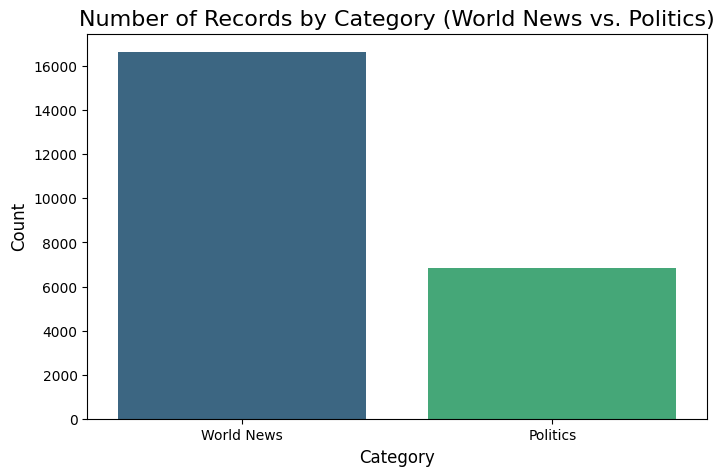

In [97]:
# Broji number of records za svaku category
category_counts = dataset['category'].value_counts()

# Kriejta bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Number of Records by Category (World News vs. Politics)", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.show()

**EDA**

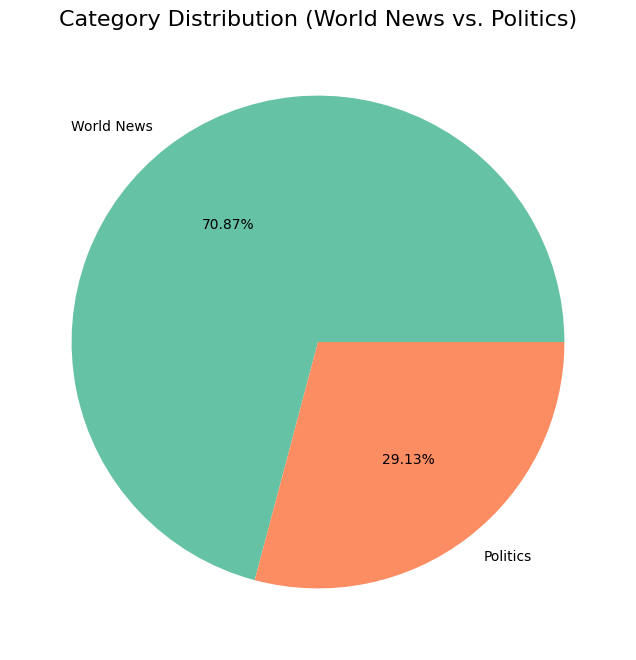

In [98]:
# Count the values in the 'category' column
category_counts = dataset['category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct="%0.2f%%", colors=['#66c2a5', '#fc8d62'])
plt.title("Category Distribution (World News vs. Politics)", fontsize=16)
plt.show()

**General Info**

In [99]:
# Broji number of character po artiklu i pravi novu kolonu
dataset['num_characters_per_article'] = dataset['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)


print("\nDataset with Number of Characters per Article:")
print(dataset[['text', 'num_characters_per_article']].head())



Dataset with Number of Characters per Article:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

   num_characters_per_article  
0                        2893  
1                        1898  
2                        3597  
3                        2774  
4                        2346  


In [100]:
dataset.head()

,title,text,subject,date,category,cleaned_text,num_characters_per_article
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",World News,donald trump wish americans happy new year lea...,2893
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",World News,house intelligence committee chairman devin nu...,1898
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",World News,friday revealed former milwaukee sheriff david...,3597
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",World News,christmas day donald trump announced would bac...,2774
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",World News,pope francis used annual christmas day message...,2346


In [101]:
nltk.download('punkt_tab')
# Broji number of words po artiklu i pravi novu kolonu num words
dataset['num_words'] = dataset['text'].apply(lambda x: len(word_tokenize(str(x))) if pd.notnull(x) else 0)


print("\nDataset with Number of Words per Article:")
print(dataset[['text', 'num_words']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Dataset with Number of Words per Article:
                                                text  num_words
0  Donald Trump just couldn t wish all Americans ...        599
1  House Intelligence Committee Chairman Devin Nu...        331
2  On Friday, it was revealed that former Milwauk...        689
3  On Christmas day, Donald Trump announced that ...        519
4  Pope Francis used his annual Christmas Day mes...        458


In [102]:
# Calculate the number of sentences per article and add a new column
dataset['num_sentences'] = dataset['text'].apply(lambda x: len(sent_tokenize(str(x))) if pd.notnull(x) else 0)


print("\nDataset with Number of Sentences per Article:")
print(dataset[['text', 'num_sentences']].head())


Dataset with Number of Sentences per Article:
                                                text  num_sentences
0  Donald Trump just couldn t wish all Americans ...             28
1  House Intelligence Committee Chairman Devin Nu...             11
2  On Friday, it was revealed that former Milwauk...             25
3  On Christmas day, Donald Trump announced that ...             15
4  Pope Francis used his annual Christmas Day mes...             19


In [103]:
# General statistics for "text".

dataset[['num_characters_per_article','num_words','num_sentences']].describe()

,num_characters_per_article,num_words,num_sentences
count,23481.000000,23481.000000,23481.000000
mean,2547.396235,470.039010,14.919509
std,2532.884399,457.154988,13.792339
min,1.000000,0.000000,0.000000
25%,1433.000000,266.000000,7.000000
50%,2166.000000,403.000000,13.000000
75%,3032.000000,562.000000,19.000000
max,51794.000000,9958.000000,288.000000


In [104]:
# General statistics for "World News"
world_news_stats = dataset[dataset['category'] == 'World News'][['num_characters_per_article', 'num_words', 'num_sentences']].describe()


print("\nGeneral Statistics for 'World News':")
print(world_news_stats)



General Statistics for 'World News':
       num_characters_per_article     num_words  num_sentences
count                16640.000000  16640.000000   16640.000000
mean                  2736.378966    505.484615      15.927885
std                   2612.630854    471.206980      13.561841
min                      1.000000      0.000000       0.000000
25%                   1754.000000    327.000000       9.000000
50%                   2293.000000    428.000000      14.000000
75%                   3090.250000    575.000000      20.000000
max                  51794.000000   9958.000000     275.000000


In [105]:
# General statistics for "Politics"
politics_stats = dataset[dataset['category'] == 'Politics'][['num_characters_per_article', 'num_words', 'num_sentences']].describe()


print("\nGeneral Statistics for 'Politics':")
print(politics_stats)



General Statistics for 'Politics':
       num_characters_per_article    num_words  num_sentences
count                 6841.000000  6841.000000    6841.000000
mean                  2087.715977   383.821371      12.466745
std                   2262.749298   408.406751      14.039359
min                      1.000000     0.000000       0.000000
25%                    715.000000   133.000000       4.000000
50%                   1655.000000   305.000000       9.000000
75%                   2789.000000   509.000000      16.000000
max                  49705.000000  7826.000000     288.000000


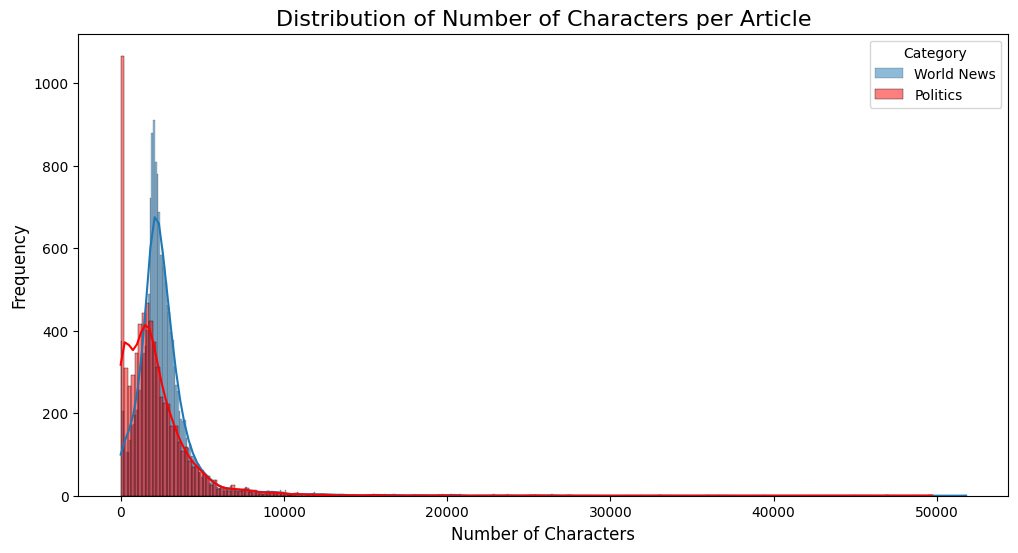

In [106]:
# Plot the distribution of the number of characters per article for World News and Politics
plt.figure(figsize=(12, 6))

# World News distribution
sns.histplot(dataset[dataset['category'] == 'World News']['num_characters_per_article'], label='World News', kde=True)


sns.histplot(dataset[dataset['category'] == 'Politics']['num_characters_per_article'], color='red', label='Politics', kde=True)


plt.title("Distribution of Number of Characters per Article", fontsize=16)
plt.xlabel("Number of Characters", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Category", fontsize=10)
plt.show()

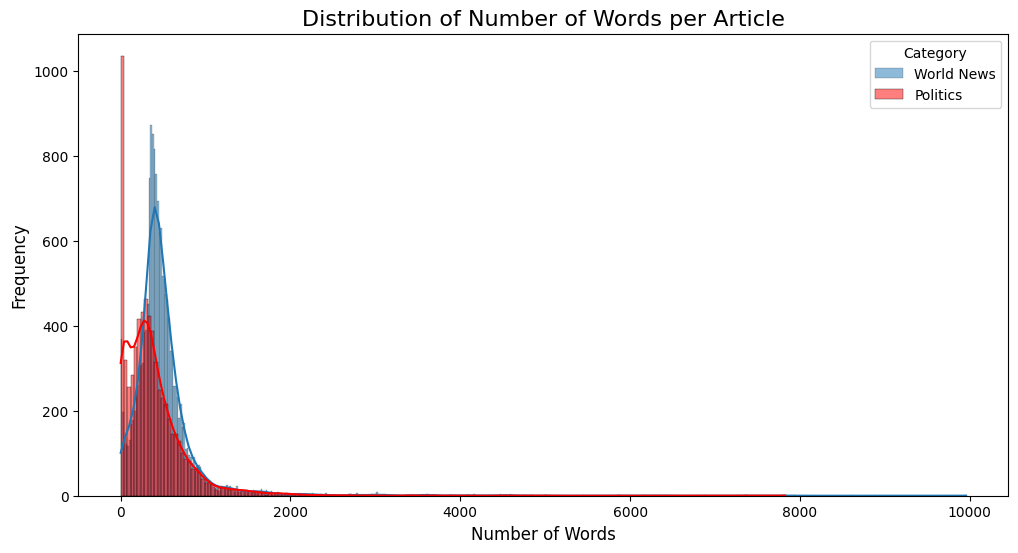

In [107]:
# Plot the distribution of the number of words per article for World News and Politics
plt.figure(figsize=(12, 6))


sns.histplot(dataset[dataset['category'] == 'World News']['num_words'], label='World News', kde=True)


sns.histplot(dataset[dataset['category'] == 'Politics']['num_words'], color='red', label='Politics', kde=True)


plt.title("Distribution of Number of Words per Article", fontsize=16)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Category", fontsize=10)
plt.show()


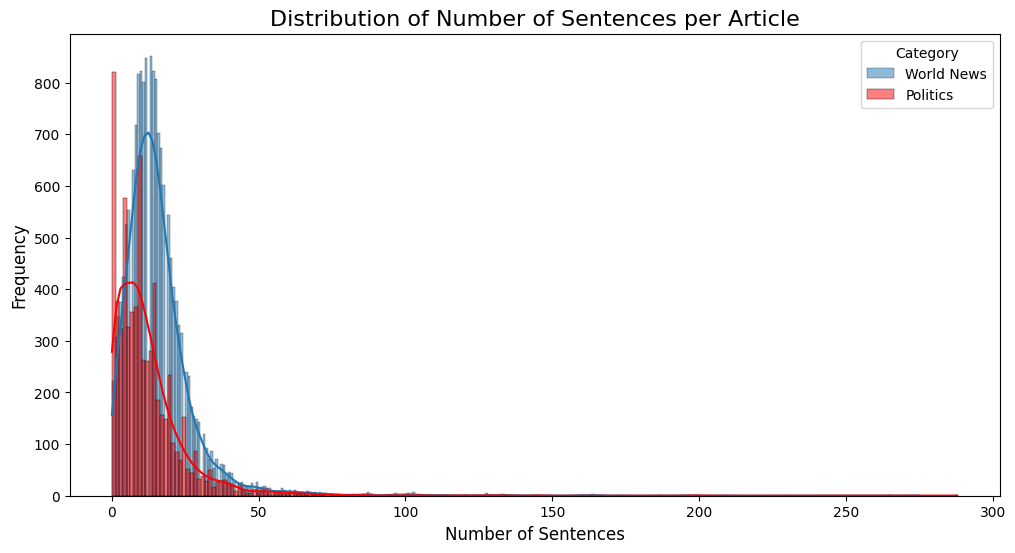

In [108]:
# Plot the distribution of the number of sentences per article for World News and Politics
plt.figure(figsize=(12, 6))


sns.histplot(dataset[dataset['category'] == 'World News']['num_sentences'], label='World News', kde=True)


sns.histplot(dataset[dataset['category'] == 'Politics']['num_sentences'], color='red', label='Politics', kde=True)


plt.title("Distribution of Number of Sentences per Article", fontsize=16)
plt.xlabel("Number of Sentences", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Category", fontsize=10)
plt.show()


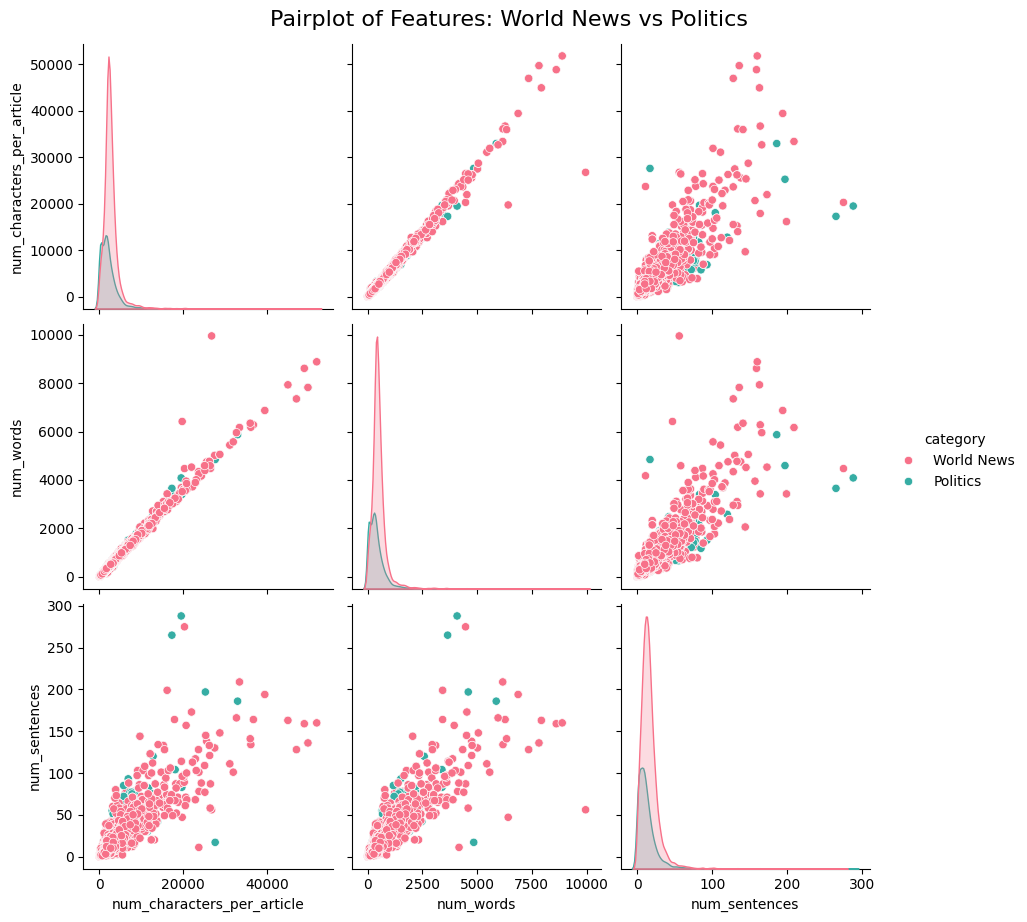

In [109]:
# Pairplot to visualize relationships between features
sns.pairplot(
    dataset,
    hue='category',
    vars=['num_characters_per_article', 'num_words', 'num_sentences'],
    palette='husl',
    height=3
)

plt.suptitle("Pairplot of Features: World News vs Politics", y=1.02, fontsize=16)
plt.show()


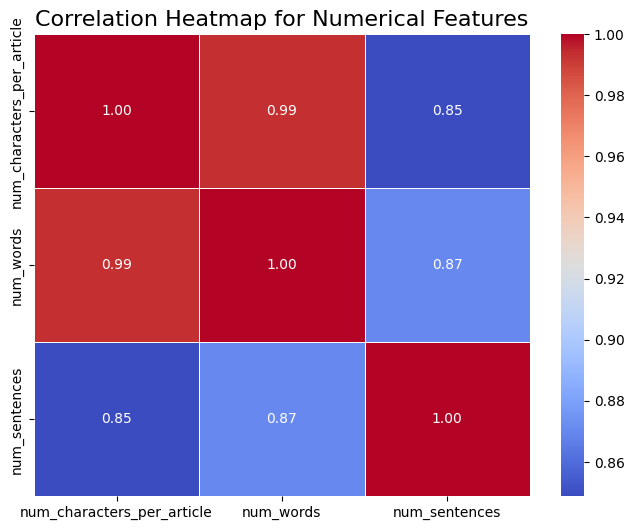

In [110]:
# Select only numerical columns
numeric_columns = dataset.select_dtypes(include=['number'])


correlation_matrix = numeric_columns.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title("Correlation Heatmap for Numerical Features", fontsize=16)
plt.show()


**Cleaning dataset, data preprocessing**




In [111]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title                       23481 non-null  object
 1   text                        23481 non-null  object
 2   subject                     23481 non-null  object
 3   date                        23481 non-null  object
 4   category                    23481 non-null  object
 5   cleaned_text                23481 non-null  object
 6   num_characters_per_article  23481 non-null  int64 
 7   num_words                   23481 non-null  int64 
 8   num_sentences               23481 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


In [112]:
# Importing regular expression for pattern matching - data cleaning.

import re

def cleanTxt(text):
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'([a-z])\1+', r'\1', text)

    return text

In [113]:
from nltk.corpus import stopwords
def tokenization_and_cleaning(text):
    word_tokens = nltk.word_tokenize(text)

    # Clean words in sentence
    clean_word_tokens = [cleanTxt(w) for w in word_tokens]

    # Remove stop words, non-alphabetic words
    clean_word_tokens_filtered = [w.lower() for w in clean_word_tokens if w.lower() not in stopwords and w.isalpha()]

    return " ".join(clean_word_tokens_filtered)

In [114]:
# Example of tokenized sentence from dataset:
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')


stopwords = set(stopwords.words('english'))


tokenization_and_cleaning('Breaking: The government is naturally introducing irresistible offers for corporate growth in 2025!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'breaking government naturaly introducing iresistible ofers corporate growth'

In [115]:
# Add a new column 'text_cleaned' to store the cleaned and tokenized text
dataset['text_cleaned'] = dataset['text'].apply(lambda mail: tokenization_and_cleaning(str(mail)) if pd.notnull(mail) else [])


print("\nDataset with Cleaned Text:")
print(dataset[['text', 'text_cleaned']].head())



Dataset with Cleaned Text:
                                                text  \
0  Donald Trump just couldn t wish all Americans ...   
1  House Intelligence Committee Chairman Devin Nu...   
2  On Friday, it was revealed that former Milwauk...   
3  On Christmas day, Donald Trump announced that ...   
4  Pope Francis used his annual Christmas Day mes...   

                                        text_cleaned  
0  donald trump wish al americans hapy new year l...  
1  house inteligence comite chairman devin nunes ...  
2  friday revealed former milwauke sherif david c...  
3  christmas day donald trump anounced would back...  
4  pope francis used anual christmas day mesage r...  


In [116]:
# check for duplicate values

dataset.duplicated().sum()

3

In [117]:
# remove duplicates

dataset = dataset.drop_duplicates(keep = 'first')


In [118]:
dataset.duplicated().sum()

0

In [119]:
porter = nltk.PorterStemmer()

def word_stemm(text):
    words = nltk.word_tokenize(text)
    porter_words = [porter.stem(word) for word in words]
    return " ".join(porter_words)


dataset['text_cleaned'] = dataset['text_cleaned'].apply(word_stemm)

In [120]:
# Apply Lemmatier



nltk.download('wordnet')

lemma = nltk.WordNetLemmatizer()
print(lemma.lemmatize('Breaking: The government is naturally introducing irresistible offers for corporate growth in 2025!'))

Breaking: The government is naturally introducing irresistible offers for corporate growth in 2025!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Frequency Distribution**


Word Frequency Distribution:
[('trump', 74988), ('said', 31157), ('presid', 28247), ('peopl', 26122), ('al', 25963), ('wil', 24166), ('one', 23892), ('state', 23870), ('ben', 23760), ('would', 23468)]


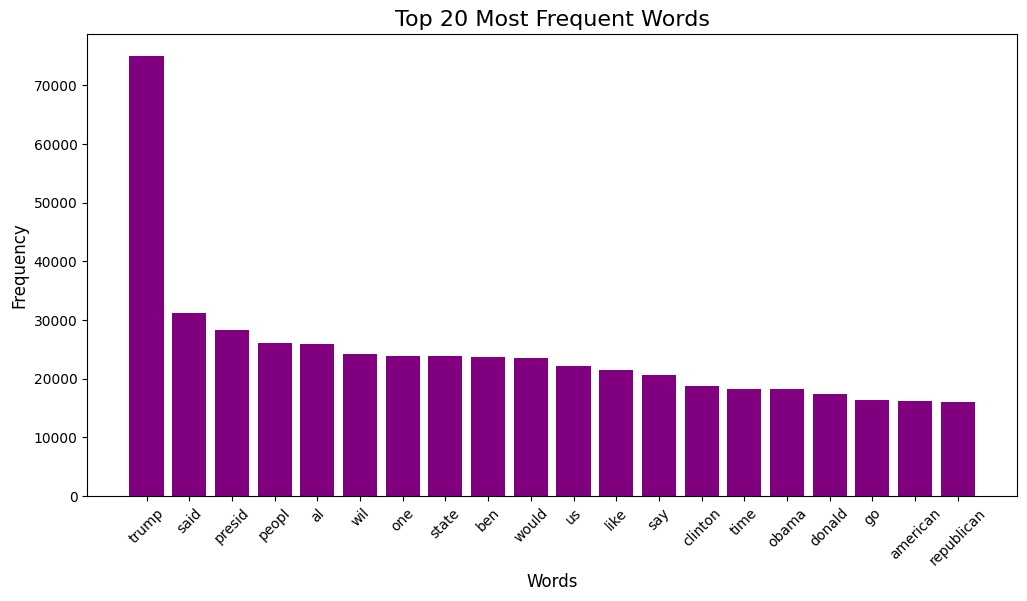

In [121]:
import re
from nltk.probability import FreqDist

# Split the cleaned text into lists of words
word_lists = dataset['text_cleaned'].apply(lambda x: re.split(r"\W+", x))

# Combine all the word lists into a single list
all_words = []
for word_list in word_lists:
    all_words += word_list


word_frequencies = FreqDist(all_words)


print("\nWord Frequency Distribution:")
print(word_frequencies.most_common(10))


import matplotlib.pyplot as plt

most_common_words = word_frequencies.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='purple')
plt.title("Top 20 Most Frequent Words", fontsize=16)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.show()


In [140]:
dataset['text_cleaned_stemmed'] = [porter.stem(mail) for mail in dataset['text_cleaned']]

In [123]:
dataset

,title,text,subject,date,category,cleaned_text,num_characters_per_article,num_words,num_sentences,text_cleaned,text_cleaned_stemmed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",World News,donald trump wish americans happy new year lea...,2893,599,28,donald trump wish al american hapi new year le...,donald trump wish al american hapi new year le...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",World News,house intelligence committee chairman devin nu...,1898,331,11,hous intelig comit chairman devin nune go bad ...,hous intelig comit chairman devin nune go bad ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",World News,friday revealed former milwaukee sheriff david...,3597,689,25,friday reveal former milwauk sherif david clar...,friday reveal former milwauk sherif david clar...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",World News,christmas day donald trump announced would bac...,2774,519,15,christma day donald trump anounc would back wo...,christma day donald trump anounc would back wo...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",World News,pope francis used annual christmas day message...,2346,458,19,pope franci use anual christma day mesag rebuk...,pope franci use anual christma day mesag rebuk...
...,...,...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",World News,st century wire says wire reported earlier wee...,3237,553,10,st centuri wire say wire report earlier wek un...,st centuri wire say wire report earlier wek un...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",World News,st century wire says familiar theme whenever d...,1684,333,12,st centuri wire say familiar theme whenev disp...,st centuri wire say familiar theme whenev disp...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",World News,patrick henningsen st century wireremember oba...,25065,4591,109,patrick heningsen st centuri wirerememb obama ...,patrick heningsen st centuri wirerememb obama ...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",World News,st century wire says al jazeera america go his...,2685,508,10,st centuri wire say al jazera america wil go h...,st centuri wire say al jazera america wil go h...


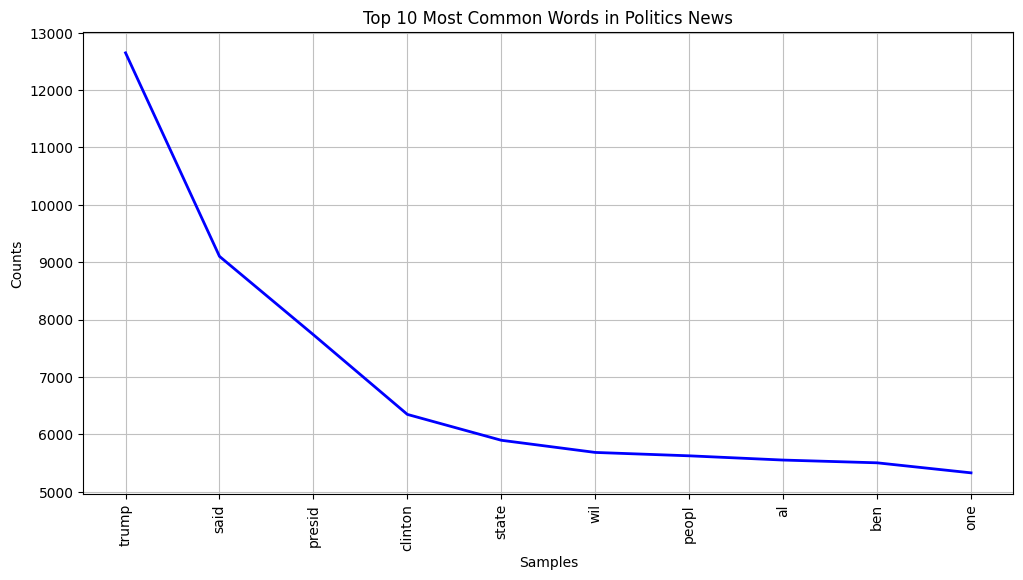

In [124]:
# Top 10 Most Common Words in Politics
politics_news = dataset[dataset['category'] == 'Politics']['text_cleaned_stemmed']


all_words_politics = [word for article in politics_news for word in nltk.word_tokenize(article)]


fdist_politics = nltk.FreqDist(all_words_politics)


plt.figure(figsize=(12, 6))
fdist_politics.plot(10, title="Top 10 Most Common Words in Politics News", color='blue')

plt.show()


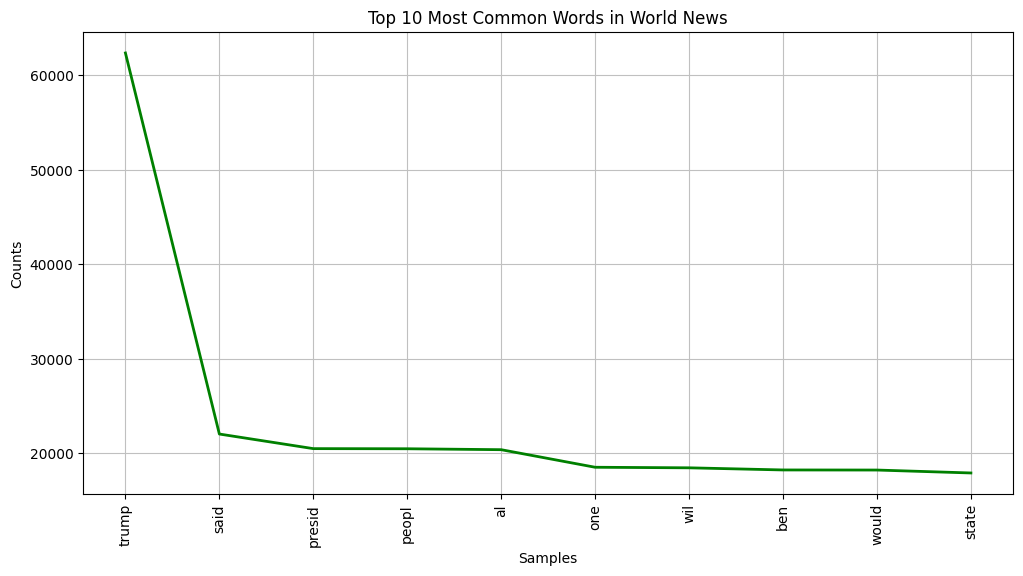

In [125]:
# Top 10 Most Common Words in Worlds news
world_news = dataset[dataset['category'] == 'World News']['text_cleaned_stemmed']


all_words_world = [word for article in world_news for word in nltk.word_tokenize(article)]


fdist_world = nltk.FreqDist(all_words_world)


plt.figure(figsize=(12, 6))
fdist_world.plot(10, title="Top 10 Most Common Words in World News", color='green')

plt.show()


**Developing Model Prediction**

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenizacija i sekvenciranje
max_words = 10000  # Maksimalni broj jedinstvenih reči
max_len = 200  # Maksimalna dužina sekvenci

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(dataset['text_cleaned_stemmed'])


sequences = tokenizer.texts_to_sequences(dataset['text_cleaned_stemmed'])


X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')


dataset['category_label'] = dataset['category'].apply(lambda x: 0 if x == 'politics' else 1)
y = dataset['category_label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Kreiranje LSTM modela
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 370s 615ms/step - accuracy: 0.9952 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 1.4115e-05
Epoch 2/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 372s 598ms/step - accuracy: 1.0000 - loss: 1.6176e-05 - val_accuracy: 1.0000 - val_loss: 5.9867e-06
Epoch 3/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 367s 572ms/step - accuracy: 1.0000 - loss: 7.4770e-06 - val_accuracy: 1.0000 - val_loss: 3.1991e-06
Epoch 4/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 383s 574ms/step - accuracy: 1.0000 - loss: 4.3991e-06 - val_accuracy: 1.0000 - val_loss: 1.7992e-06
Epoch 5/5
587/587 ━━━━━━━━━━━━━━━━━━━━ 409s 621ms/step - accuracy: 1.0000 - loss: 2.4209e-06 - val_accuracy: 1.0000 - val_loss: 1.0849e-06
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 191ms/step - accuracy: 1.0000 - loss: 1.0848e-06
Test Loss: 1.0848879128388944e-06
Test Accuracy: 1.0


In [144]:
# Primeri tekstova za testiranje
test_texts = [
    "The government is planning to introduce new tax reforms next year.",
    "A recent earthquake shook the Middle East, causing widespread destruction.",
    "Elections are coming up soon, and political parties are ramping up their campaigns.",
    "The US and China have entered negotiations to resolve trade disputes."
]

# Pretvaranje tekstova u sekvence koristeći prethodno definisan tokenizer
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Dodavanje paddinga za jednaku dužinu sekvenci
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Predikcija modela
predictions = model.predict(test_padded)


for i, text in enumerate(test_texts):
    category = "World News" if predictions[i] > 0.5 else "Politics"
    print(f"Text: {text}")
    print(f"Predicted Category: {category}")
    print(f"Prediction Score: {predictions[i][0]:.2f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text: The government is planning to introduce new tax reforms next year.
Predicted Category: World News
Prediction Score: 1.00

Text: A recent earthquake shook the Middle East, causing widespread destruction.
Predicted Category: World News
Prediction Score: 1.00

Text: Elections are coming up soon, and political parties are ramping up their campaigns.
Predicted Category: World News
Prediction Score: 1.00

Text: The US and China have entered negotiations to resolve trade disputes.
Predicted Category: World News
Prediction Score: 1.00



In [147]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# VEKTORISANJE
cv = CountVectorizer(max_features=3000)
tfidf = TfidfVectorizer(max_features=3000)

# Fit and transform the 'text_cleaned_stemmed' KOLONU Ya countvectorizer
X_cv = cv.fit_transform(dataset['text_cleaned_stemmed'])

# Fit and transform the 'text_cleaned_stemmed' kolonu za tfidvectorizer
X_tfidf = tfidf.fit_transform(dataset['text_cleaned_stemmed'])


print(f"CountVectorizer Matrix Shape: {X_cv.shape}")
print(f"TfidfVectorizer Matrix Shape: {X_tfidf.shape}")


print("\nTop Words (CountVectorizer):", cv.get_feature_names_out()[:10])
print("\nTop Words (TfidfVectorizer):", tfidf.get_feature_names_out()[:10])


CountVectorizer Matrix Shape: (23478, 3000)
TfidfVectorizer Matrix Shape: (23478, 3000)

Top Words (CountVectorizer): ['abandon' 'abc' 'abedin' 'abil' 'abl' 'abort' 'abroad' 'absolut' 'absurd'
 'abus']

Top Words (TfidfVectorizer): ['abandon' 'abc' 'abedin' 'abil' 'abl' 'abort' 'abroad' 'absolut' 'absurd'
 'abus']


In [145]:
# "X" represents dataset's TF-IDF features

X = tfidf.fit_transform(dataset['text_cleaned_stemmed']).toarray()

In [146]:
X.shape

(23478, 3000)

In [129]:
y = dataset['category'].apply(lambda x: 1 if x == 'World News' else 0).values


In [148]:
# Split dataset u training i testing set


from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [149]:
# Import three different Naive Bayes classifiers.

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [150]:
# Instantiating three classifiers from scikit-learn:

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [151]:
# Trenira GaussianNB classifier.

gnb.fit(x_train,y_train)
y_pred1 = gnb.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

1.0
[[4696]]
1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [152]:
# Trenira BernoulliNB classifier.

bnb.fit(x_train,y_train)
y_pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

1.0
[[4696]]
1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [153]:
#Multiple klasefajera

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt
}

In [154]:
# Define a function that takes a classifier "clf" and trains it.

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)

    return accuracy,precision

For GaussianNB:
Accuracy - 1.0
Precision - 1.0
For MultinomialNB:
Accuracy - 1.0
Precision - 1.0
For BernoulliNB:
Accuracy - 1.0
Precision - 1.0


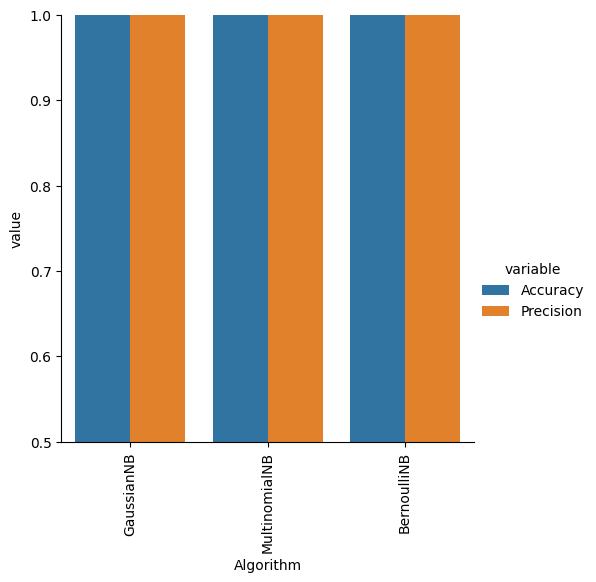

In [155]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)


clfs = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}


def train_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    return accuracy, precision


accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, x_train, y_train, x_test, y_test)
    print(f"For {name}:")
    print(f"Accuracy - {current_accuracy}")
    print(f"Precision - {current_precision}")
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)


performance_dataset = pd.DataFrame({
    'Algorithm': list(clfs.keys()),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores
}).sort_values('Precision', ascending=False)


performance_dataset1 = pd.melt(performance_dataset, id_vars="Algorithm")


sns.catplot(x='Algorithm', y='value', hue='variable', data=performance_dataset1, kind='bar', height=5)
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()


In [156]:
performance_dataset = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [157]:
performance_dataset

,Algorithm,Accuracy,Precision
0,GaussianNB,1.0,1.0
1,MultinomialNB,1.0,1.0
2,BernoulliNB,1.0,1.0
